# Libraries import

## Add and build these packages, if required

## Importing required packages

In [1]:
using LinearAlgebra
using PyPlot
using ForwardDiff
using RobotZoo
using RobotDynamics
import RobotDynamics as RD
using MatrixCalculus
using JLD2
using StaticArrays
using Rotations
using DifferentialEquations

# Dynamics consruction

In [2]:
#Acrobot Dynamics
a = RobotZoo.Quadrotor()
h = 0.05

0.05

In [3]:
?RobotZoo.Quadrotor

```
Quadrotor{R}
```

A standard quadrotor model, with simple aerodynamic forces. The orientation is represent by a general rotation `R`. The body z-axis point is vertical, so positive controls cause acceleration in the positive z direction.

# Constructor

```
Quadrotor(; kwargs...)
Quadrotor{R}(; kwargs...)
```

where `R <: Rotation{3}` and defaults to `UnitQuaternion{Float64}` if omitted. The keyword arguments are

  * `mass` - mass of the quadrotor, in kg (default = 0.5)
  * `J` - inertia of the quadrotor, in kg⋅m² (default = `Diagonal([0.0023, 0.0023, 0.004])`)
  * `gravity` - gravity vector, in kg/m² (default = [0,0,-9.81])
  * `motor_dist` - distane between the motors, in m (default = 0.1750)
  * `km` - motor torque constant (default = 0.0245)
  * `kf` - motor force constant (default = 1.0)


In [4]:
    # Constants
    g = 9.81  # Gravity (m/s^2)
    m = 0.5   # Mass of the quadrotor (kg)
    l = 0.1750  # Arm length (m)
    kf = 1.0  # Motor force constant
    km = 0.0245  # Motor torque constant
    Ji = Diagonal([0.0023, 0.0023, 0.004])  # Inertia matrix (kg*m^2)

3×3 Diagonal{Float64, Vector{Float64}}:
 0.0023   ⋅       ⋅ 
  ⋅      0.0023   ⋅ 
  ⋅       ⋅      0.004

In [5]:
function R_f(angles)
    # Identical to RotZYX(reversed(angles))
    γ, β, α = angles
    cγ, sγ = cos(γ), sin(γ)
    cβ, sβ = cos(β), sin(β)
    cα, sα = cos(α), sin(α)
    
    return [
        cα * cβ  sγ * sβ * cα - cγ * sα  sγ * sα + cγ * sβ * cα;
        cβ * sα  cγ * cα + sγ * sβ * sα cγ * sα - sγ * cα;
        -sβ sγ * cβ cγ * cβ
    ]
end

R_f (generic function with 1 method)

In [6]:
function euler_dot(angles, omegas)
    omega_x, omega_y, omega_z = omegas
    γ, β, α = angles
    if abs(β - pi/2) < 0.001
        β += 0.01
    end
    phi_dot=omega_x+(sin(γ)*tan(β))*omega_y+(cos(γ)*tan(β))*omega_z
    theta_dot=cos(γ)*omega_y-sin(γ)*omega_z
    psi_dot=(sin(γ)/cos(β))*omega_y+(cos(γ)/cos(β))*omega_z
    return [phi_dot, theta_dot, psi_dot]
end


euler_dot (generic function with 1 method)

In [7]:
function quadrotor_dynamics(x, u)
    # State decomposition
    p = x[1:3]  # Position (x, y, z)
    euler_angles = x[4:6]  # Orientation (roll, pitch, yaw)
    R = R_f(euler_angles)
    v = x[7:9]  # Linear velocity (vx, vy, vz)
    omega = x[10:12]  # Angular velocity (p, q, r)
    w = u.^2
    # Compute thrust and torques
    Fz = kf * sum(w)  # Total thrust force
    tau_x = kf * l * (w[4] - w[2])  # Roll torque
    tau_y = kf * l * (w[3] - w[1])  # Pitch torque
    tau_z = km * (w[1] - w[2] + w[3] - w[4])  # Yaw torque
    tau = [tau_x; tau_y; tau_z]

    dp = R * v
    # Rotation matrix (body to world)
    phi, theta, psi = euler_angles
    # try
    

        # Translational dynamics
    
    dv = (1/m) * ([0; 0; Fz]) - R'  * [0; 0; g] - cross(omega, v)
    
    # Angular dynamics
    domega = Ji \ (tau - cross(omega, Ji * omega))
    
    # Euler angle derivatives
    deuler =[0,0,0]

    deuler = euler_dot(euler_angles, omega)
    
    # State derivative
    dx = vcat(dp, deuler, dv, domega)
    return dx
end


quadrotor_dynamics (generic function with 1 method)

In [8]:
function dynamics_rk4(x,u)
    #RK4 integration with zero-order hold on u
    f1 = quadrotor_dynamics(x, u)
    f2 = quadrotor_dynamics(x + 0.5*h*f1, u)
    f3 = quadrotor_dynamics(x + 0.5*h*f2, u)
    f4 = quadrotor_dynamics(x + h*f3, u)
    xn = x + (h/6.0)*(f1 + 2*f2 + 2*f3 + f4)
    return xn
end

dynamics_rk4 (generic function with 1 method)

In [9]:
function dfdx(x,u)
    return ForwardDiff.jacobian(dx->dynamics_rk4(dx,u),x)
end

function dfdu(x,u)
    return ForwardDiff.jacobian(du->dynamics_rk4(x,du),u)
end

dfdu (generic function with 1 method)

In [10]:
Nx = 12   # number of state
Nu = 4     # number of controls
Tfinal = 2.0 # final time
Nt = Int(Tfinal/h)+1    # number of time steps
thist = Array(range(0,h*(Nt-1), step=h));

# Cost function

In [11]:
# Cost weights
Q = Diagonal([1.0 * ones(6); 0.1 * ones(6)]);
R = Array(0.001*I(Nu));
Qn = Array(1000.0*I(Nx));

In [12]:
function stage_cost(x,u)
    return 0.5*((x-xgoal)'*Q*(x-xgoal)) + 0.5(u'*R*u)
end

stage_cost (generic function with 1 method)

In [13]:
function terminal_cost(x)
    return 0.5*(x-xgoal)'*Qn*(x-xgoal)
end

terminal_cost (generic function with 1 method)

In [14]:
function cost(xtraj,utraj)
    J = 0.0
    for k = 1:(Nt-1)
        J += stage_cost(xtraj[:,k],utraj[:,k])
        # display(J)
    end
    J += terminal_cost(xtraj[:,Nt])
    
    return J
end

cost (generic function with 1 method)

# iLQR

## Backward pass

In [15]:
function backward_pass!(p,P,d,K)
    
    ΔJ = 0.0
    p[:,Nt] .= Qn*(xtraj[:,Nt]-xgoal)
    P[:,:,Nt] .= Qn
    
    for k = (Nt-1):-1:1
        #Calculate derivatives
        q = Q*(xtraj[:,k]-xgoal)
        r = R*utraj[:, k]
    
        A = dfdx(xtraj[:,k], utraj[:,k]) #ForwardDiff.jacobian(dx->dynamics_rk4(dx,utraj[k]),xtraj[:,k])
        B = dfdu(xtraj[:,k], utraj[:,k]) #ForwardDiff.derivative(du->dynamics_rk4(xtraj[:,k],du),utraj[k])
        
    
        gx = q + A'*p[:,k+1]
        gu = r + B'*p[:,k+1]
    
        #iLQR (Gauss-Newton) version
        Gxx = Q + A'*P[:,:,k+1]*A
        Guu = R + B'*P[:,:,k+1]*B
        Gxu = A'*P[:,:,k+1]*B
        Gux = B'*P[:,:,k+1]*A
        
        
        β = 0.1
        while !isposdef(Symmetric([Gxx Gxu; Gux Guu]))
            Gxx += A'*β*I*A
            Guu += B'*β*I*B
            Gxu += A'*β*I*B
            Gux += B'*β*I*A
            β = 2*β
            # display("regularizing G")
            # display(β)
        end
        
        d[:,k] .= Guu\gu
        K[:,:,k] .= Guu\Gux
    
        p[:,k] .= gx - K[:,:,k]'*gu + K[:,:,k]'*Guu*d[:,k] - Gxu*d[:,k]
        P[:,:,k] .= Gxx + K[:,:,k]'*Guu*K[:,:,k] - Gxu*K[:,:,k] - K[:,:,k]'*Gux
    
        ΔJ += gu'*d[:,k]
    end
    
    return ΔJ
end

backward_pass! (generic function with 1 method)

## Initial conditions

In [16]:
#Initial guess
uhover = ((m*g/4)*ones(4)).^0.5
x0 = [0.0; 0;  0; 0; 0; 0.0; 0; 0; 0; 0; 0; 0]
xgoal = [0.0; 0; 0; pi/6; 0; 0; 0; 0; 0; 0; 0; 0]
xtraj = kron(ones(1,Nt), x0)
utraj = zeros(Nu, Nt-1) .+ uhover
#f = jldopen("guess.jld2", "r")
#utraj = f["utraj"];

In [17]:
#Initial Rollout
for k = 1:(Nt-1)
    xtraj[:,k+1] .= dynamics_rk4(xtraj[:,k],utraj[:,k])
end
J = cost(xtraj,utraj)

164.9839066848227

## iLQR iterations

In [18]:
#DDP Algorithm
p = ones(Nx,Nt)
P = zeros(Nx,Nx,Nt)
d = ones(Nu,Nt-1)
K = zeros(Nu,Nx,Nt-1)
ΔJ = 1.0

xn = zeros(Nx,Nt)
un = zeros(Nu,Nt-1)

gx = zeros(Nx)
gu = zeros(Nu)
Gxx = zeros(Nx,Nx)
Guu = zeros(Nu)
Gxu = zeros(Nx)
Gux = zeros(Nx)

iter = 0
Jp = 0
stop = false
while abs(Jp-J) >  5 * 1e-5
    if stop
        break
    end
    iter += 1    
    
    #Backward Pass
    ΔJ = backward_pass!(p,P,d,K)

    #Forward rollout with line search
    xn[:,1] = xtraj[:,1]
    α = 1.0
    
    # display(K[:,:,1] * (xn[:,1]-xtraj[:,1]))
    # display(utraj[:,1] - α*d[:,1] - K[:,:,1] * (xn[:,1]-xtraj[:,1]))
    
    for k = 1:(Nt-1)
        un[:,k] .= utraj[:,k] - α*d[:,k] - K[:,:,k] * (xn[:,k]-xtraj[:,k])
        try
            xn[:,k+1] .= dynamics_rk4(xn[:,k],un[:,k])
        catch e
            stop = true 
            break
        end
    end
    Jn = cost(xn,un)
    # display(Jn)
    while isnan(Jn) || Jn > (J - 1e-2*α*ΔJ)
        if stop
            break
        end
        α = 0.5*α
        for k = 1:(Nt-1)
            un[:,k] .= utraj[:,k] - α*d[:,k] - K[:,:,k] * (xn[:,k]-xtraj[:,k])
            try
                xn[:,k+1] .= dynamics_rk4(xn[:,k],un[:,k])
            catch e
                stop = true
            end
        end
        Jn = cost(xn,un)
        display(Jn)
    end
    Jp = J
    J = Jn
    xtraj .= xn
    utraj .= un
    
end

3249.00140933111

230.70076347404145

46.00820688147982

33.3384168062505

32.31919258836139

32.24017139116504

3915.754595577122

272.63162642268867

48.99231984003886

33.588573200231835

32.31704803271773

32.20059911105179

4774.103535349241

326.62945648284165

52.845319197619375

33.93058819699524

32.33795724870827

32.17477121527523

5898.8265000232595

397.378712694039

57.89726053335917

34.39635056207975

32.388255010373356

32.165687238438494

7403.103283989614

491.9552269065256

64.6438674888533

35.03294259619366

32.477000617176756

32.177519889586236

32.14390884196359

8356.097757365527

551.2534936168847

68.70258304892154

35.366242961269926

32.50359622935838

32.16574895172054

32.12469873409803

9480.932733054931

621.1953730084616

73.48064479616109

35.76057705938899

32.5398164337493

32.1578100067914

32.108324435578695

10818.85446503145

704.3204961506337

79.14703063817294

36.229464637081726

32.58743839284896

32.15423337718672

32.09511044054098

12423.790007520767

803.9443400826381

85.92175088777826

36.79036528768427

32.64871478248224

32.15567614420627

32.08545315789529

14367.209303159263

924.4536058597085

94.09509158646506

37.46612220949399

32.72653556928423

32.16296059071479

32.07984082063477

16745.268088337103

1071.7390399434364

104.05573579334873

38.287056724827735

32.824658371875486

32.177127392933436

32.07888039985252

19689.52238127823

1253.8427406827234

116.33269886110378

39.29406831201455

32.94804288777956

32.19951054155419

32.08333457251587

32.06848388848121

21440.120011704097

1361.6073800034785

123.47228439830678

39.8433333916245

33.001619499466635

32.20060614868553

32.07562785122528

32.05879395201214

23409.997499998924

1482.763420851718

131.48454716414307

40.45773151521232

33.062433135998624

32.203438508125814

32.06884349237336

32.04985956832424

25635.482206243778

1619.5104044748844

140.51108642215814

41.147429772864356

33.13148815638739

32.20819717585923

32.063059258582356

32.0417363660887

28160.52012774123

1774.5046998155917

150.72263378641188

41.924635385566425

33.20997730775167

32.21510342597433

32.05836453089945

32.03448776579225

31038.636589644262

1950.9757313716616

162.32640207182158

42.80410065880275

33.29932596763934

32.22441700586914

32.054862527094855

32.02818636642873

34335.50281859086

2152.8776363388956

175.57565522856638

43.8037782213831

33.401249014321124

32.236444668919944

32.05267305023981

32.02291564218586

38132.327915385125

2385.088962305341

190.78228218130903

44.945678759918046

33.51782455141088

32.25155103784355

32.05193591955285

32.01877203304576

42530.39167971314

2653.6784448851927

208.33349173920988

46.25700559247053

33.651590473489975

32.270172571671544

32.05281529041295

32.01586754065719

47657.16934911134

2966.262435410355

228.71420490021094

47.77167041451103

33.8056721684964

32.2928356841901

32.055505139590544

32.01433297738912

53674.71327468323

3332.491416942906

252.53744452440873

49.532341979794566

33.98395334511265

32.320180504641534

32.06023629819663

32.014322068418416

32.00880751352491

57099.577143044145

3540.352569995336

265.96297173177055

50.498960060424196

34.07317598577634

32.32924588131251

32.05784742257012

32.00957347085303

32.00348761746363

60833.86106584104

3766.7427074805305

280.5668304402719

51.54730309699845

34.16972571798148

32.339470849968095

32.05585025405664

32.005073100857246

31.998383379529088

64914.35481247664

4013.8301291560488

296.4852561938461

52.686565340743066

34.27436382455112

32.35095715194145

32.05427178213777

32.00083487375416

31.993505806648805

69383.33009925112

4284.099922942403

313.87415745004336

53.92724363782317

34.38795404383214

32.36381891043363

32.053141910749105

31.99687406470666

31.988866928373422

74289.53054839253

4580.409770553987

332.9125360284613

55.28136035918044

34.511479428750604

32.37818450727761

32.05249385639453

31.99320747815171

31.984479918008418

79689.3720662176

4906.057233081341

353.8065995438456

56.76273072761693

34.64606244973312

32.394198795178944

32.05236461118267

31.989853642887212

31.980359231357617

85648.40707042675

5264.861332335637

376.79473261249234

58.38728512065725

34.79298910128723

32.412025720955164

32.05279548431875

31.986833037608456

31.97652076611646

92243.11880889328

5661.26184529156

402.15352691337847

60.1734589006537

34.95373789228956

32.431851443042255

32.05383273652032

31.984168352251025

31.97298204549789

99563.1329485162

6100.440773936495

430.2051303441906

62.14266608470155

35.130014867806956

32.453888052723194

32.05552832623173

31.981884791842038

31.96976243040489

107713.95877073477

6588.47164091875

461.3262416794674

64.3198771716423

35.32379607539349

32.47837803059019

32.057940789810914

31.980010430762608

31.96688336530095

116820.40787951236

7132.503937337886

495.9591704160495

66.7343271234347

35.537379275270894

32.50559960422549

32.06113628323145

31.978576627052494

31.964368663974966

127030.88368838983

7740.992080167215

534.6254909430061

69.42038598509924

35.7734471130391

32.53587320622589

32.06518981745661

31.97761850804618

31.96224484257585

138522.80271160926

8423.981315451218

577.9429878586426

72.41863473905047

36.03514466252731

32.56956929391333

32.07018672924757

31.9771755414871

31.960541508862697

151509.4923228755

9193.466465880392

626.6467659871533

75.77719906229044

36.32617486297128

32.607117834681

32.076224434115474

31.97729220824992

31.95929181826286

166249.0361492823

10063.844715338286

681.6156715225519

79.55340951054256

36.650916410732265

32.64901984754268

32.08341452039497

31.978018796442946

31.958533009431047

183055.70955446913

11052.49030350866

743.9054969269791

83.81587481282682

37.01456978031642

32.6958614721503

32.091885253067616

31.979412339888892

31.958307034336432

202314.88530046615

12180.48757854507

814.7908337266422

88.64707562105208

37.42333823390804

32.74833110860213

32.10178456217776

31.981537726450814

31.958661300217248

31.955718923209158

213064.8546222163

12807.577966364708

854.0507100966865

91.29639533548767

37.64000350136686

32.773057272953004

32.104347761542854

31.980146424955233

31.9563727923198

31.953208681674173

224624.77137612345

13480.115226830514

896.0917770808549

94.12733646872782

37.870528799684806

32.799347347545854

32.10723844023037

31.978887658498312

31.954175240489235

31.950779492655943

237074.21575081954

14202.32634282844

941.1654057991924

97.15588098836727

38.11606539033616

32.82731595836529

32.11047674816874

31.97776817019849

31.952072672324704

31.94843474579757

250502.44489110727

14978.913260661533

989.5500338333335

100.39968057769804

38.37787922651316

32.85708806050005

32.11408442897211

31.976795185320885

31.95006938641519

31.94617805316772

265009.8015181692

15815.114463557175

1041.5544348877459

103.87824932726744

38.6573634921711

32.888799950203506

32.118084953814105

31.975976448380393

31.948169972881068

31.944013266142296

280709.3631976758

16716.775391317617

1097.5214001302159

107.61317854905703

38.956052450278236

32.92260036408487

32.122503663480025

31.97532026227175

31.946379335246345

31.94194449349638

297728.87833333475

17690.428939639074

1157.8318699553402

111.62837502668245

39.275636629580106

32.958651660277724

32.12736791671489

31.974835528947427

31.944702713547088

31.9399761207095

316213.0461010112

18743.387482486058

1222.9095567645315

115.9503238095376

39.617979352374526

32.99713107314055

32.132707242388584

31.974531791002324

31.943145708517953

31.938112830448276

336326.21679760766

19883.848456512416

1293.226123152372

120.60837785416486

39.9851346885606

33.03823204247517

32.138553494696644

31.974419273885225

31.941714306752356

31.936359624171757

358255.59593819175

21121.015054391817

1369.306926805017

125.63507264472986

40.37936657255098

33.08216557787655

32.14494100350429

31.97450892684975

31.940414906335345

31.934721844694604

382215.0664209858

22465.234409831148

1451.7373714929238

131.06646513353456

40.80316890380916

33.1291616302651

32.151906714241235

31.97481246122301

31.939254342473532

31.93320519946723

408449.7666812399

23928.155542523167

1541.1698598249661

136.94249244334154

41.259286125958

33.17947040752883

32.15949030594816

31.975342383250908

31.938239912275012

31.931815784180085

437241.6049061905

25522.909882526907

1638.331331755467

143.30734377492854

41.750733606036015

33.23336355558996

32.16773427400154

31.976112018271117

31.937379397596846

31.930560106131235

468915.92784461414

27264.316625598833

1744.0312703317773

150.20983042540428

42.28081645039057

33.29113505595568

32.17668395292343

31.977135520470355

31.93668108415581

31.92944510648707

503849.6457140269

29169.116481026587

1859.1700556312212

157.70373669880124

42.85314521467454

33.35310168109061

32.18638745457472

31.978427862387193

31.9361537748484

31.928478180276272

542481.1813319805

31256.235854585564

1984.7473287840949

165.84811688772876

43.471645583290154

33.41960271087369

32.19689547573751

31.9800047936244

31.93580679389157

31.92766719240711

585322.7470128154

33547.08433158208

2121.869921304243

174.7074926258896

44.140558250380366

33.49099854393811

32.208260920788966

31.981882756345453

31.93564997754245

31.9270204873765

632975.6145605762

36065.887504416205

2271.7586302771238

184.3518814480119

44.864423426447175

33.56766767222527

32.220538262112306

31.984078740077404

31.935693645500294

31.92654688946061

686149.2642251309

38840.055417959324

2435.752700606746

194.85655259149993

45.64804174458426

33.65000124699783

32.23378252774583

31.98661005113011

31.935948544740953

31.926255688942845

745685.6490071167

41900.58681345601

2615.310454035476

206.30136898822215

46.49640054565357

33.73839422829381

32.24804777619491

31.98949396552908

31.936425755115764

31.926156608403836

812590.2628725795

45282.50550288327

2812.0036776585093

218.76950725414474

47.41454948230874

33.83323166123381

32.26338485767825

31.992747221353856

31.93713654185622

31.926259740922696

31.92487255566824

849324.0286609442

47113.25855694579

2917.6439092491614

225.41998301317454

47.897134974017995

33.88086133873172

32.26989802328772

31.993145849899477

31.936260378126338

31.92507870058102

31.92361522949804

888392.1566875182

49040.358247888624

3028.238332920494

232.35917046711276

48.39885424102536

33.93015287797614

32.276655164303605

31.993613642884547

31.935420802891365

31.923926803278164

31.92238523007457

929988.8166681256

51069.59360817839

3144.008615780253

239.5972687770862

48.92024297015094

33.98113715253638

32.28365855985049

31.994151260559345

31.934618408940505

31.922804646407354

31.921183157136134

974328.773334776

53207.09883655445

3265.1777562622124

247.14400027777296

49.461781933423765

34.03383847619283

32.29090937646191

31.9947591185148

31.933853729610714

31.92171281233212

31.920009606373373

1.0216501515401433e6

55459.368062833324

3391.9678458495077

255.00838473752708

50.02387868148051

34.08827287082487

32.29840742183108

31.995437335355373

31.933127223728103

31.92065186196476

31.9188651651264

1.072217679411222e6

57833.27063561965

3524.5973470793065

263.1984706193192

50.606845968082524

34.14444605087804

32.306150862183806

31.996185672951807

31.932439258304118

31.919622327267476

31.917750407288835

1.1263264765065056e6

60336.06487819534

3663.277665236206

271.7210070797732

51.21087571047747

34.20235101407571

32.314135887578836

31.99700346602276

31.931790088148347

31.91862470239952

31.916665887279226

1.184306542748006e6

62975.412967024815

3808.2090887305103

280.5810601656061

51.836008752077404

34.26196527478964

32.322356332414536

31.997889542653354

31.931179832687516

31.917659433475688

31.915612132967386

1.2465280546373955e6

65759.39424555012

3959.5758033808784

289.78155191672454

52.482098873216216

34.32324759677136

32.330803230719454

31.998842131524917

31.93060844890959

31.916726906586376

31.914589637382175

1.313407693932352e6

68696.52024455296

4117.540061563934

299.3227260391587

53.14877134005923

34.38613426507307

32.33946431412594

31.999858757575375

31.930075700722806

31.91582743401968

31.91359884905684

1.3854161997721375e6

71795.74930551423

4282.235210458942

309.2015187193622

53.835374446696704

34.450534757038625

32.34832343282383

32.000936122014444

31.92958112366264

31.91496123831567

31.912640160812465

1.4630874659433325e6

75066.50414510343

4453.757620142284

319.4108356182247

54.540924165042824

34.51632683495704

32.35735990456209

32.002069967770694

31.929123985060535

31.914128434029614

31.911713896796083

1.5470295311333416e6

78518.69278656266

4632.15733312924

329.938721714524

55.26404097857079

34.58335098065115

32.36654778087964

32.00325492809382

31.928703239003433

31.913329006901378

31.910820297563664

1.637937926589139e6

82162.73542546846

4817.427368915444

340.76741850039775

56.00287856986115

34.651404148960324

32.37585502793485

32.00448435767569

31.9283174757751

31.912562790196773

31.909959502989768

1.7366119842895572e6

86009.60184491615

5009.491720252205

351.8723105312963

56.755044600931086

34.72023286835365

32.38524262610994

32.005750146971536

31.927964865771592

31.911829438052795

31.90913153279788

1.843974842920687e6

90070.86346201562

5208.19200595459

363.2207595404174

57.517513583281854

34.789525689330404

32.394663587316664

32.007042519186875

31.927643097594117

31.91112839559899

31.908336264501155

1.9610981175502874e6

94358.76735712786

5413.27292216675

374.7708375461088

58.28653284001699

34.85890507112331

32.40406190070127

32.00834981164827

31.92734931053915

31.910458865745344

31.907573408566297

2.089232495305239e6

98886.34374168399

5624.366858186571

386.46998714704506

59.05752382508098

34.92791890705672

32.413371431315085

32.00965824590464

31.92708002232417

31.90981977270207

31.90684248067658

2.2298458252434847e6

103667.55797221107

5840.97796950587

398.25363506908076

59.82498098781166

34.99603187038004

32.42251479079681

32.01095168947228

31.92683105257539

31.90920972225929

31.906142771007197

2.3846708003562503e6

108717.52662939327

6062.466491158073

410.0438208291036

60.58237303939816

35.06261699874207

32.43140223011521

32.01221141815212

31.92659744402011

31.908626959235214

31.905473310547528

2.555764911281436e6

114052.81981213935

6288.034169111283

421.7479129000042

61.32205234565491

35.12694799890429

32.43993060935322

32.013415888435986

31.926373383524353

31.90806932263518

31.904832834632533

2.7455862206235817e6

119691.88157804165

6516.712219319734

433.2575246843059

62.0351811599174

35.18819301178951

32.447982532072466

32.0145405357276

31.92615212663577

31.907534199534307

31.904219744053357

2.957089537227066e6

125655.60368155697

6747.353287157759

444.44775241706833

62.71168426985393

35.24541063786542

32.45542573548802

32.01555761442863

31.92592592948531

31.907018478898326

31.903632064328008

3.193849173297696e6

131968.1057504043

6978.629824655071

455.1769243505235

63.34024257131277

35.297549459057635

32.462112885406576

32.01643610729507

31.925685994700462

31.90651850740117

31.90306740407983

3.4602163656668635e6

138657.7775303813

7209.041130877736

465.28704391368933

63.90834175226319

35.34345224828437

32.46788191488162

32.01714172931171

31.925422437724002

31.906030049512108

31.90252291379756

3.7615223838546975e6

145758.6613771921

7436.932248105327

474.6051731483488

64.40239486044949

35.38186647285605

32.47255710349503

32.01763706320762

31.92512428297833

31.90554825512079

31.901995246750083

4.104342231531677e6

153312.26199208538

7660.527709197801

482.94598700585965

64.80795638291761

35.411462601885006

32.47595108341621

32.01788186232365

31.924779499395356

31.90506763836581

31.90148052429606

4.496839729802447e6

161369.8948104959

7877.983559483108

490.1157458784397

65.1100464111048

35.43086184366515

32.47786798371061

32.01783356311172

31.924375086835813

31.904582072190802

31.900974308399853

4.949223418916493e6

169995.70017575796

8087.46042970835

495.9178693619102

65.29359838817702

35.43867453444743

32.47810788427454

32.01744804401473

31.923897224224582

31.904084803417717

31.900471584658884

5.474356526398018e6

179270.48211250038

8287.22010290822

500.16023407974404

65.34403872227095

35.43355001419296

32.47647272311876

32.01668066555645

31.923331490428986

31.903568493573328

31.899966759631134

6.088586866218377e6

189296.55615459353

8475.746398008967

502.66415622986176

65.24799365522387

35.41423777559409

32.47277369017787

32.01548760916231

31.92266316557447

31.903025290271753

31.89945367651089

6.81290228213706e6

200203.8350038819

8651.889621402828

503.27483913379854

64.99410402001908

35.37965847768764

32.466840018682134

32.013827513502086

31.92187761673949

31.90244693325986

31.89892565322327

7.674590753356155e6

212157.43558337566

8815.031553992452

501.8728199939418

64.57390862349406

35.328981760319785

32.45852890255707

32.011663376596736

31.920960765297806

31.901824897640616

31.898375546631673

8.709728039168036e6

225367.1677569543

8965.265439556939

498.3856768685247

63.98273489235686

35.26170591464326

32.44773604943868

32.008964653214484

31.919899624221227

31.9011505743258

31.89779584565968

9.967111124992266e6

240099.37404055428

9103.583131683905

492.7989956576774

63.22051429744563

35.17773260204213

32.43440614506775

32.00570943278375

31.918682882814647

31.900415484445183

31.897178794628587

1.151488938377192e7

256691.75099587635

9232.06035554485

485.1654230346111

62.29242581148848

35.07742845270975

32.4185423085002

32.00188654177094

31.917301505414784

31.899611520602036

31.89651654603215

1.3452555314910747e7

275572.00231037306

9354.030903200035

475.610565205683

61.20926558587422

34.961664689576324

32.40021346845481

31.997497376259247

31.915749299441526

31.89873120350972

31.895801339315213

1.5934196700212374e7

297281.4879731749

9474.243008749183

464.33464500605896

59.98745359073696

34.83182666130368

32.37955858583076

31.992557253785083

31.914023401095786

31.897767938711414

31.895025699273244

1.921657353617002e7

322505.45866903424

9598.995855848878

451.60919046688485

58.64861795065139

34.68978734645289

32.356786792107556

31.987096080131842

31.912124624635947

31.896716255160385

31.894182644730463

2.3764180241944287e7

352112.0417176825

9736.261674473657

437.76861190503575

57.2187459476348

34.53784266960477

32.33217285151571

31.98115816839966

31.910057626708348

31.895572006432914

31.893265895674578

3.0489591307746764e7

387202.9076142913

9895.80823543444

423.19723140300493

55.72694919179322

34.37861126368337

32.306047841584935

31.97480112019502

31.907830850467203

31.894332516609623

31.892270065466118

4.132335565739871e7

429179.55922892777

10089.347383148368

408.31306260667606

54.2039505604549

34.21490648189134

32.27878554099971

31.96809378051376

31.905456235619713

31.892996656867915

31.89119082455963

6.060175860987523e7

479830.5091509382

10330.745840646556

393.55021356190866

52.680446915561475

34.04959274687388

32.25078558245621

31.961113387915272

31.90294870598647

31.891564844946974

31.890025023560906

9.852338585201806e7

541446.3626212397

10636.344858897506

379.34210978408873

51.185525421499555

33.88544095771734

32.22245489132469

31.953942147537486

31.900325473175695

31.890038967422385

31.888770766428312

1.7997862197740299e8

616972.1261126429

11025.444357896919

366.1076926071715

49.74530325613559

33.72499775028164

32.19418915317932

31.946663528281903

31.89760521687014

31.88842223253771

8.549735344975702e8

832285.6121930666

12184.995574115514

343.7291728501631

47.06595457712416

33.42118782345364

32.1408974801657

31.93433895767372

31.894325458485195

31.887345728617234

5.384871041757194e9

1.174640271899869e6

14073.831833602224

330.0981915625346

44.823378870822594

33.153416270413395

32.09120326060731

31.922052294628344

31.89049054620423

31.885583640259576

3.9195000593700195e10

1.73332515300304e6

17126.171573174463

328.28547582195563

43.08020854314655

32.92879391929964

32.04683984821312

31.9102798331182

31.88625301347711

31.883206054325154

3.2324762468613776e11

2.6666025486779166e6

22060.565043760183

341.99192235335977

41.84772919617481

32.74852457777119

32.00862095870437

31.899320951331205

31.881743668373726

1.3867961936088392e14

7.704078295792962e6

46568.00493197344

457.89250847206006

40.919159128759716

32.50206385022399

31.95202729381358

31.884201987339118

31.876853576844194

4.637807820735387e17

2.963465241824281e7

127220.16275069892

852.5344450973857

42.834177053810365

32.410251539958075

31.916737899063005

31.87115146752016

5.415502693024977e28

1.2373376565136445e14

6.083297032366934e6

25118.99944690973

157.9387255931001

33.59597685207274

31.93427381233188

31.86053612976595

8.63320061492213e31

2.0579074155162477e17

2.144148547984953e7

80688.1087339225

392.84527917884435

35.33339461865015

31.977483580769025

31.85263527829031

9.914122135168503e26

3.6569212763597197e12

3.196581728474834e6

13605.937472991276

106.59450181430951

33.110330816259435

31.900426466757775

31.84167753577579

6.686729366801212e34

1.683305701936573e20

1.7697891693286896e8

236436.35375309197

1022.6365913406247

39.077170370278075

32.05028771359551

31.838633629488303

1.570842240577994e23

1.1594797962390491e10

808643.6580350868

3844.3758840929513

59.693928549408554

32.576691215420695

31.870861625432433

31.828304840927718

3.285479189631525e33

7.864014500348261e18

5.101251685952147e7

141097.98600765076

622.6826560912748

36.57419466914129

31.970463898362823

31.820871985745384

9.032722597798707e23

3.414073498885087e10

1.0606184861824855e6

4907.300343599062

65.24987296610766

32.63471336834965

31.855705591357697

31.810535051347337

4.471371100492951e23

1.7912976205904606e10

826570.585886009

3310.8399319917535

50.33855697148094

32.19320050463841

31.801491524146197

1.6687865502542322e19

8.222735049512848e7

209786.4769566776

1250.4059088968284

45.47511063490176

32.3795088865248

31.840374916788715

31.79508046525507

1.3922069007484457e31

3.2345401402663584e16

1.534875050027279e7

60527.24951222043

310.56821849808233

34.76547197586054

31.901904825039747

31.787420081821804

4.205891502342315e28

9.733675791386339e13

5.857668098828749e6

24318.79832681769

155.54467489773933

33.54437350384791

31.855932959670227

31.778051058652522

6.395311107309517e32

1.5655587243339177e18

3.3243985953683265e7

111882.94022922283

523.6961304967258

36.19436277466748

31.926252563723274

31.772691301673934

2.142882609539696e26

1.180188789609545e12

2.515112673037794e6

10914.132869168208

94.91857306681513

32.953497425595664

31.822064022394475

31.76294535125697

8.19009474526368e35

2.073901658457952e21

6.96197651534572e8

355896.4627405615

1496.7244408114777

41.63751751755046

32.03176786898311

31.76363986451615

31.755042304629704

5.00707061463533e35

1.27194060002348e21

5.261076806963698e8

329560.8562303755

1397.3430293422389

41.15539527595584

32.01642700671338

31.755621198073644

31.74718368861807

9.196524614864071e35

2.3328329125067413e21

7.469641050650555e8

363117.34223685245

1526.4893971721428

41.78290319492728

32.01946900272555

31.74821249749356

31.739361878520917

5.956439065217914e35

1.514752157161867e21

5.821291502001814e8

339183.586312218

1435.6343018464986

41.33651043573518

32.004554608427

31.74024867345113

31.73157819365067

1.015303191031557e36

2.579428232309669e21

7.934631381871709e8

369390.7921303806

1552.2186973832652

41.9038610720874

32.00670606782738

31.732896663182498

31.7238334298614

6.933499051617285e35

1.7652452687627632e21

6.366072878192995e8

347875.2948899053

1470.2910963034599

41.49853005405829

31.992445956843355

31.725010153531

31.716123508259074

1.1167968503397437e36

2.841445025432548e21

8.41113127665021e8

375514.54579320515

1577.209350935232

42.01921195818687

31.993902655624808

31.717714550137842

31.708453696384964

7.96836199126968e35

2.0311877566005578e21

6.914731699649647e8

356066.4944222808

1503.0135465151236

41.650482246066304

31.980277918089996

31.7099109104322

31.70081676180675

1.229590601628214e36

3.1329893658551874e21

8.922627412704743e8

381782.0740174116

1602.6872808307633

42.1360447333632

31.98122008563945

31.70267424807911

31.693220680126217

9.085723792409817e35

2.319004098186462e21

7.480115149387144e8

363999.2691254285

1534.755970798223

41.797395291051636

31.968147170814266

31.69495354819472

31.68565616203385

1.3574889717786345e36

3.463992738477606e21

9.482528402462006e8

388320.49693512183

1629.1902134966444

42.257505156979505

31.968730327647926

31.68777910466735

31.678133018545758

1.0308221559997997e36

2.634630857320051e21

8.071836028825439e8

371822.0371689269

1566.1026021337054

41.94232300425023

31.956111202063894

31.680139405650603

31.670640464321828

1.5039105536334147e36

3.843448375485498e21

1.0100747873703651e9

395193.21087839804

1656.9895567918702

42.38518652841576

31.95646939493178

31.67303058303604

31.663189704696673

1.165812832784691e36

2.983951957892882e21

8.697752091253829e8

379631.120780486

1597.4322449019319

42.08722940396274

31.944206100021177

31.665469153322363

31.65576873376055

1.672447758977584e36

4.280852996255868e21

1.0786304904836884e9

402437.8529742173

1686.2472506265615

42.52002477100709

31.944457485735583

31.658429329061384

31.648389948163167

1.3158303008044645e36

3.3730465701027224e21

9.364709577796916e8

387491.19303546665

1628.9991711701916

42.23342212647273

31.932455223336344

31.650943078214624

31.64104022601012

1.8671992231032503e36

4.78707374931102e21

1.1548573397977297e9

410082.3530470422

1717.082443517626

42.66268147862243

31.932707661216458

31.643975627220424

31.6337331005159

1.483271376681414e36

3.808330182723384e21

1.0078918569539974e9

395446.02880812116

1660.9756016943322

42.38177966575084

31.920873732443393

31.63656122859051

31.626454322811377

2.0930417697581314e36

5.375066245635733e21

1.2398041556202471e9

418152.5364213022

1749.6032194607812

42.81372672563167

31.92122998997742

31.629669616438147

31.619218613052446

1.6706628291635223e36

4.296611796868192e21

1.0846106870202227e9

403524.25675937784

1693.4744011886694

42.5328729972425

31.909471023378124

31.622323488006128

31.61201049485413

2.3559177706177483e36

6.060638752492732e21

1.3346920092830582e9

426676.2397127585

1783.923784955236

42.97373727553237

31.910033736827963

31.61551140261412

31.604846011707266

1.880644629389238e36

4.845059453699383e21

1.1671506946459606e9

411742.22555131756

1726.5603656107803

42.687026820422105

31.898251982438225

31.608229609111536

31.59770827909678

2.66318810418298e36

6.86339410685485e21

1.4409764637205262e9

435686.0117380316

1820.1756573215657

43.14335863675167

31.89912867488649

31.601501124313938

31.59061488144335

2.115905532483736e36

5.461041776720499e21

1.2559681904099596e9

420104.96359502984

1760.2539818348591

42.84434147302683

31.887217493187062

31.59427922089352

31.58354726387101

3.0241007243328425e36

7.807983044575102e21

1.5604222895843227e9

445221.3806058511

1858.51689678199

43.32335374715532

31.88852602185967

31.58763899729131

31.576524855904

2.379048657221825e36

6.151786219502168e21

1.3514162392103736e9

428605.64624696464

1794.5292982032365

43.00468459734958

31.876364389554038

31.580471814721854

31.569527077990916

3.450439745279415e36

8.925843574424951e21

1.6952011565145793e9

455331.22973023634

1899.141605172966

43.51465052311144

31.878239258341633

31.573925350534203

31.562575609789473

2.6723509893727e36

6.923758888532885e21

1.453683403360782e9

437223.65168422536

1829.306225166273

43.16765467596259

31.865684914024904

31.56680670954455

31.55564738143499

3.957450218550782e36

1.0257680966917707e22

1.8480251785243025e9

466076.65400228516

1942.2911891894173

43.71839611528242

31.868284978525864

31.560360660561702

31.54876685218727

2.9973620642700104e36

7.781620621132392e21

1.5626978098099353e9

445921.045782645

1864.4366292646735

43.33251359791211

31.855165647810434

31.553282992822155

31.54190785571096

4.56518484920992e36

1.1857076959355477e22

2.0223339977703934e9

477534.60107221705

1988.2685928195478

43.93602373795222

31.858683869192724

31.5469455873683

31.53509831932102

3.354262535521948e36

8.726546277841042e21

1.6779823868864393e9

454637.12357557367

1899.6827366258933

43.49808107478793

31.84478580184506

31.539899430125313

31.52830819203174

5.300501958673482e36

1.3795838889610193e22

2.222560518549115e9

489802.5672481729

2037.4565350543576

44.169336643166616

31.84946187316092

31.533681012575784

31.521569764959857

3.7408745674017127e36

9.753613007706965e21

1.79844208909558e9

463280.419743509

1934.6855017186538

43.66257933405096

31.83451467987892

31.526654332231114

31.514848075001925

6.200075342732746e36

1.6172058508011468e22

2.454510135938732e9

503004.524735382

2090.3403886581405

44.42061131160797

31.84065153220704

31.520568076036408

31.5081809460206

4.1511922210735545e36

1.0847893924321167e22

1.9220597546682808e9

471717.4028130008

1968.9197963335455

43.8234123449975

31.82430804902981

31.5135453638924

31.501527158570735

7.31497572219846e36

1.912239728041227e22

2.7258984107145357e9

517297.96386121877

2147.5351294694206

44.692715295884476

31.832293369989884

31.507608198470358

31.494931599423726

4.573308838472953e36

1.1978909076163171e22

2.045478222838432e9

479756.97858617426

2001.6328882072526

43.97686153661145

31.81410310273444

31.500569274121773

31.488345029348768

8.717654528759512e36

2.284084760104469e22

3.047096138641519e9

532881.121720105

2209.8125043346886

44.98921810366244

31.824436864479104

31.494803059335844

31.48182140355252

4.9867277616954054e36

1.3093364751185757e22

2.163463452075076e9

487130.2275433513

2031.7638060006705

44.11768479048075

31.803811756220135

31.487721527057776

31.475301149731354

1.0512421456091772e37

2.7606911551139607e22

3.432108440576237e9

549997.4412555707

2278.1164504869453

45.31443263777418

31.817139860855338

31.482154460246917

31.46884991279537

5.359396295538772e36

1.4107037289665087e22

2.268300876201788e9

493466.185822564

2057.846578154716

44.23863079315231

31.793312386677933

31.474995824584344

31.46239476925119

1.2850340997801853e37

3.3825731835312705e22

3.899693452828146e9

568929.5909979233

2353.5360459724334

45.673232339662064

31.810463774570337

31.469663924696807

31.456016445167545

5.645646618783497e36

1.4898895297164484e22

2.349320816038342e9

498268.50593513524

2077.916154568825

44.329956975178014

31.782441314408015

31.462383559721935

31.449624787098813

1.5947365244315137e37

4.207723344899963e22

4.474076292153649e9

589965.1687688039

2437.1648735908275

46.07029408128659

31.8044589107163

31.45733173137241

31.443319888996157

5.787817717060078e36

1.5314824792005293e22

2.3930429530608807e9

500907.5606396026

2089.47425755718

44.37922730446251

31.770988349468887

31.449873373023646

31.43698954276887

2.0095819880341972e37

5.3148193983732805e22

5.183642856180116e9

613296.3978427837

2529.697715689572

46.50804867595524

31.799128836978056

31.445154818424047

31.430758374632145

5.726395398615101e36

1.519396757515771e22

2.384895342571432e9

500662.54729743383

2089.651824480488

44.372061319702595

31.75870732344772

31.437451290606923

31.4244865098396

2.563261709164643e37

6.794943680407392e22

6.052482506131271e9

638786.2208215414

2630.4990914396208

46.98209268256074

31.79435582264883

31.433122696444137

31.418328740603528

5.42378164831597e36

1.4431744175173458e22

2.3138432810781884e9

496880.20886597113

2075.8329562916556

44.29516048402304

31.745364051455

31.425102488350916

31.412111883902266

3.2767972009025016e37

8.706043662997368e22

7.077486908332068e9

665521.9306102102

2735.8392387757076

47.47271812497745

31.78977109514428

31.421210730843686

31.406025759879654

4.899550164773282e36

1.3074668101659605e22

2.1805663189085703e9

489341.0159962758

2047.1047517985983

44.14349385846734

31.730855682619623

31.41281637417049

31.399860126456144

4.113300912964071e37

1.0951934728140951e23

8.18206438736222e9

691221.0579065064

2836.573069772885

47.93417089226523

31.784604470491697

31.40937297694192

31.393841342799714

4.2558506106906314e36

1.1390619854790396e22

2.0063608634051528e9

478853.5282140961

2006.6248507674068

43.93227999136674

31.715418716322056

31.400596176479866

31.387723736450557

4.920996162752849e37

1.3128831142253074e23

9.176213541673857e9

712166.882873913

2917.9715719559845

48.29502217849157

31.777729720009457

31.39754616092169

31.381764708574842

3.6563109808289616e36

9.815713595680602e21

1.834154947667534e9

467761.73720838845

1963.6653665856302

43.70774590978424

31.69983086296323

31.388469442991067

31.375693990483654

5.489613384847059e37

1.4674291699649072e23

9.847589069871513e9

725294.5037874596

2968.1107140060735

48.500198848019735

31.768364923177803

31.385688215538025

31.3697856189887

3.249898058184386e36

8.752027886359251e21

1.7125104947048752e9

459481.025602659

1931.8071012367982

43.53866299712054

31.685288445847736

31.376485554869728

31.36376387252777

5.816981838010334e37

1.558130080779046e23

1.0232833949939753e10

732483.7335219869

2994.8896414146807

48.593192016533045

31.7573518000956

31.373845759483817

31.357901243765063

3.093454431127153e36

8.357949818713109e21

1.6676461581672716e9

456431.8295037823

1920.7261040748683

43.47474487976227

31.672682003035465

31.36468646994642

31.3519329881939

6.205455233245189e37

1.6661489373228843e23

1.0683002385687674e10

740729.4198706025

3026.4204488161126

48.71465307829944

31.747039155265284

31.36214661290152

31.346119783144868

3.138703347522902e36

8.509141270094904e21

1.6887875076733143e9

458165.60719090945

1928.690903729699

43.50775609604838

31.661887502212032

31.35307453639993

31.340209253688748

6.911502524078208e37

1.8608625839973828e23

1.1466175470078959e10

754596.821356456

3080.79932900158

48.952275497293925

31.738811938565114

31.350668292536373

31.334453356795528

3.296045408023627e36

8.967422389088765e21

1.7467687991894014e9

462510.66474079544

1947.0862696038268

43.594110245932136

31.65214938547158

31.34162429776881

31.328602793967598

7.949740321593963e37

2.1469136715558322e23

1.2563862105485725e10

772935.1332032223

3153.199459755767

49.279593786823156

31.732162647905117

31.33938775544665

31.322909448056887

3.506323430669023e36

9.574660035080077e21

1.8213917042556114e9

467901.9616117994

1969.6921437738663

43.702242120306536

31.642917664882212

31.33031583937341

31.31711963603962

9.259806533952412e37

2.5087510601047933e23

1.3879798539881079e10

793426.1869965818

3234.2281669353233

49.64878020605005

31.726270257367016

31.328263822106237

31.311490734478117

3.750578621189473e36

1.0280788566446673e22

1.9059563167428675e9

473801.4487483185

1994.370835227952

43.82130639507403

31.634003513172605

31.31914245671927

31.30576196544239

1.0833118330951898e38

2.944852353521826e23

1.5378399640705355e10

815090.1854895289

3319.9296805911504

50.03984136666659

31.720795926534173

31.31727952241997

31.300198068314476

4.027959810660069e36

1.1084941341405963e22

1.9997460504441411e9

480111.25807224435

2020.736377639214

43.94934781757529

31.62537269219765

31.30810333241598

31.294530556569338

1.270878190467997e38

3.4668014078390357e23

1.707153613410167e10

837766.0185375016

3409.651010846434

50.44937947342997

31.71567822336796

31.306432052741712

31.28903197397903

4.3421267089369095e36

1.1998820290639335e22

2.1034312118481107e9

486826.97452170315

2048.7750403144555

44.086298208752

31.617023635769964

31.297198949369278

31.283425943871183

1.4948983741427797e38

4.0927586930593945e23

1.898677315650545e10

861492.5426258079

3503.544015877977

50.87800143814873

31.710921136819366

31.295721987481507

31.277992984857246

4.697836427916203e36

1.3037501918015767e22

2.217931364033121e9

493955.0048644775

2078.516382913818

44.23230869644534

31.608958557929512

31.28642998652183

31.2724486812671

1.7631724040941508e38

4.8456062996637434e23

2.1157937090434795e10

886331.0845743478

3601.850990434435

51.3267543489558

31.706535412919294

31.28515028683401

31.26708167926593

5.100700498349903e36

1.4218872074171069e22

2.3443154581549954e9

501504.5510571002

2110.00132295114

44.387587978129545

31.60118065731237

31.2757972154606

31.261599370659127

2.0853130107711434e38

5.753718770780581e23

2.362322705124366e10

912347.5064197517

3704.8325566872027

51.79676678571677

31.70253269644905

31.274718001683393

31.25629868678677

5.557305459172902e36

1.5564079890196448e22

2.4838138432409368e9

509487.1386404131

2143.2802930245953

44.55239293635136

31.593693947543812

31.26530149826267

31.250878667862462

2.4731965849586994e38

6.85238648267704e23

2.642880590171498e10

939612.4983203465

3812.7688034163393

52.28925300267054

31.698925538504916

31.26442627745254

31.245644693930977

6.07534726683294e36

1.709806311675474e22

2.637830656618623e9

517916.10254198505

2178.4112246575132

44.72701841959103

31.58650307562818

31.25494378405884

31.24028728782687

2.941521070360999e38

8.185609562004874e23

2.962760348245759e10

968201.279024899

3925.958078203595

52.80550590294191

31.695727236881684

31.254276348894642

31.235120448581778

6.663793435455391e36

1.885019378643953e22

2.8079602041984468e9

526806.2320219368

2215.458164342723

44.91179024852858

31.579613197068966

31.24472510718118

31.2298260087826

3.508506971188963e38

9.808368593598448e23

3.3282560663974953e10

998193.4933478311

4044.7165910297745

53.346894215763854

31.692951749401786

31.24426953818334

31.22472676368405

7.333067809824346e36

2.0855043079944293e22

2.996005583957456e9

536173.4496843225

2254.4900237017036

45.10705893279978

31.573029864696345

31.234646585221867

31.219495675663318

4.19677289456726e38

1.1789512628229331e24

3.746761426259308e10

1.0296730364852061e6

4169.377745615055

53.91485856778789

31.69061359705648

31.23440725211155

31.21446452022483

8.095256316664091e36

2.315327705665825e22

3.203999419411385e9

546034.4978041351

2295.5793570526057

45.31319356098048

31.566758922164873

31.224709416589214

31.20929720282313

5.034426163400387e38

1.421544919282636e24

4.227002369100763e10

1.0627277983107201e6

4300.291171672688

54.51090634115737

31.68872775634151

31.22469097835496

31.20433466951008

8.964328006199052e36

2.5792688870406337e22

3.43422618481819e9

556406.5918795168

2338.8010059965527

45.530575062211724

31.560806388940897

31.214914876909116

31.199231576015986

6.056413650156112e38

1.7194781145810342e24

4.779262104105487e10

1.0974492433658885e6

4437.821123494111

55.13660376023282

31.687309519603666

31.21512227968604

31.194338234634067

9.956361513399153e36

2.8829369946267384e22

3.6892450981383295e9

567307.0116306525

2384.2304909554214

45.75958824245906

31.55517832729289

31.20526431368777

31.189299853502888

7.306182071086017e38

2.0864194202180384e24

5.415583378690043e10

1.1339317596781803e6

4582.3439818596835

55.79356403628793

31.686374309854592

31.20570278535876

31.18447631096311

1.108975910495391e37

3.2329012510009007e22

3.9719108539570355e9

578752.5943476899

2431.942007907652

46.000611895503674

31.549880680489867

31.195759138514823

31.17950316607425

8.837695639432439e38

2.5395888035703107e24

6.150189517997097e10

1.172271682124054e6

4734.244488175825

56.48342992377724

31.685937431225568

31.1964341786025

31.174750065365433

1.2385418533867597e37

3.636831639150579e22

4.285386895679502e9

590759.0907044312

2482.005868259917

46.25400618845951

31.54491907002252

31.18640081591565

31.169842715678353

1.0717847560270309e39

3.100677511089004e24

6.999957261982983e10

1.2125658650484807e6

4893.910218323117

57.20784852029374

31.68601373107834

31.187318178844748

31.1651607338112

1.3866814293118112e37

4.103643467249086e22

4.63313540038535e9

603340.3335368953

2534.4851802985936

46.52009632930247

31.54029853699995

31.177190847728237

31.16031977222737

1.3029271900123341e39

3.7969983709517344e24

7.984662933318098e10

1.2549096443642436e6

5061.723667780451

57.968435562222666

31.686617144381493

31.17835651696512

31.155709616834184

1.5559912211892425e37

4.643632850690361e22

5.0191136286131935e9

616507.1564722037

2589.4315144671227

46.79915124649824

31.536023208836035

31.168130751527098

31.1509356680073

1.587349829564331e39

4.6628747218681304e24

9.127194550837178e10

1.299393968038053e6

5238.051078050666

58.76672541372695

31.687760079848502

31.16955090125878

31.146398072169692

1.749280032828608e37

5.268580749356573e22

5.447057461991441e9

630265.9816751722

2646.879221894805

47.091355650121926

31.532095867080777

31.159222031179382

31.141691788918

1.9374270229651505e39

5.741301313843509e24

1.0455207931593436e11

1.3461014010279172e6

5423.226846890048

59.604101703563344

31.68945259494961

31.16090297109114

31.137227503659222

1.9694859371391237e37

5.991789828599666e22

5.921426680083846e9

644616.9688072976

2706.837963607031

47.396773288777176

31.528517384091938

31.1504661369597

31.132589561516827

2.3680628078738833e39

7.085856472323556e24

1.1999876586304373e11

1.3951005964383371e6

5617.531913125247

60.4817015908735

31.69170128625708

31.152414234075383

31.128199345194194

2.219521255695998e37

6.827998724153808e22

6.446524265756833e9

659551.5872803978

2769.282883048552

47.71529859379563

31.525285987060485

31.14186441186699

31.12363043448528

2.896898412674332e39

8.762765891496751e24

1.3797445636828278e11

1.4464387026203473e6

5821.164024742399

61.40028457222614

31.694507801813003

31.144085981482714

31.119315038079016

2.502007744110401e37

7.793086388247263e22

7.026562358301791e9

675049.4205235263

2834.141634228926

48.04659280267995

31.52239629138398

31.133418019520036

31.11481585268076

3.5442789029463316e39

1.0852939334366991e25

1.588962958700479e11

1.5001309192168873e6

6034.196781730302

62.36005224864742

31.697866833125225

31.13591917396329

31.110575999593493

2.818849332790335e37

8.90343218974138e22

7.665326489281246e9

691073.962784969

2901.2772750369077

48.38999962678381

31.519838029964248

31.125127847583073

31.10614722127184

4.3327405932620094e39

1.3453487000998575e25

1.8321625422543106e11

1.5561462324124307e6

6256.523622188217

63.360402426167866

31.70176341826955

31.127914288069487

31.10198357981903

3.170570742040422e37

1.0174730501661699e23

8.38694206879943e9

707567.0608048872

2970.465588225158

48.74443328270243

31.517594370586384

31.116994378164165

31.09762585661035

5.285626598197119e39

1.667795954292982e25

2.1143408344385614e11

1.614387779539169e6

6487.780617217846

64.39959066919735

31.706169272146717

31.120071108040072

31.093539002619533

3.555331857723929e37

1.16199793068316e23

9.129060037868189e9

724441.5858054496

3041.3651037462905

49.10823019597232

31.51563968968089

31.10901751407971

31.08925291919864

6.424225115006543e39

2.065377966361908e25

2.4404969999833847e11

1.6746661145728051e6

6727.241230377172

65.4742696393455

31.71103784654605

31.112388445959702

31.08524328537674

3.9675115194332917e37

1.324625287152252e23

9.953719468351513e9

741571.6731004325

3113.4770718493587

49.47895050983266

31.51393658958466

31.10119634434881

31.08102932252498

7.762523187302777e39

2.5514502199973884e25

2.815230785699046e11

1.7366620156610506e6

6973.669715762782

66.57884738512456

31.71629748090005

31.104863756088502

31.077097129500444

4.395768863983494e37

1.5049775166190893e23

1.0834124766846672e10

758779.8807769419

3186.0926479337336

49.8531153046286

31.512431936795963

31.093528828676906

31.072955608801706

9.298407959357434e39

3.1383045983057416e25

3.241944663399159e11

1.7998764669949694e6

7225.123747868049

67.70462431257802

31.721842266536033

31.097492619894425

31.069100771865326

4.820536008512763e37

1.7008665168588496e23

1.1758203283398256e10

775819.8034289628

3258.2212137081215

50.22584867000218

31.511051434879093

31.08601136527904

31.065031779890358

1.0999835901022105e40

3.833993144545754e25

3.721236853219195e11

1.8635584162725057e6

7478.6689180232825

68.83854170424739

31.72751871416986

31.090268003622025

31.06125378001244

5.211126925398538e37

1.9072938079306452e23

1.2704765575066763e10

792353.7598419803

3328.4980010757627

50.59041357498178

31.50969251281694

31.07863821031116

31.05725706475197

1.2785356961967948e40

4.6369956001640455e25

4.2486398630683374e11

1.9266140828822358e6

7730.019959905402

69.96161245869507

31.73310922717923

31.083179322128736

31.053554775857428

5.522898437513099e37

2.1151164888744522e23

1.3640036370116875e10

807920.6887659817

3395.051037568512

50.93754080357701

31.508213938578105

31.071400651212638

31.04962960265257

1.4498649537746203e40

5.5274504320547525e25

4.811028532166155e11

1.9874536688285747e6

7972.933126797782

71.04624067339506

31.738302966085275

31.076210851006753

31.04600103946742

5.6961474700785e37

2.309596615837549e23

1.4512499335902388e10

821900.7604798733

3455.352854460563

51.254668144526775

31.506423654766227

31.064285945275113

31.042145995211026

1.5887192287332945e40

6.456019626395114e25

5.3821453670497003e11

2.0438662060577723e6

8198.70940558398

72.05405554024108

31.742673366398876

31.069340343701015

31.03858800343715

5.658178982184201e37

2.4686869376360428e23

1.5248962703331224e10

833445.9099595689

3505.932232345388

51.52447460552508

31.504055515086108

31.057275573772827

31.03480071060349

1.6586156698042887e40

7.3253552112512635e25

5.914037403324636e11

2.092563488696459e6

8394.38154224868

72.92781186695635

31.745586055885113

31.062534287287857

31.031308396299046

5.336502644167087e37

2.5633559028276056e23

1.575246269176224e10

841463.1592660651

3542.2935302783812

51.72437403615983

31.500758167331472

31.05034363427293

31.027585150876913

1.6192158696374658e40

7.991085704807404e25

6.338577619716548e11

2.129508203616363e6

8544.011694825513

73.59727119664528

31.746268177639447

31.055750290324735

31.024151522924804

4.676363983914917e37

2.555896605897666e23

1.588893405535035e10

844347.1427680468

3557.82043842812

51.82101580252781

31.496009197965414

31.043451711216985

31.020486643387237

1.4297476284150323e40

8.211166442934823e25

6.535661647042496e11

2.1471094051370695e6

8617.533951136205

73.92895642220317

31.743222905409493

31.0489091076701

31.017100550969452

3.701525887513565e37

2.4171467869040913e23

1.553773985527516e10

840485.1615613144

3545.7784871850613

51.779650012425115

31.48923628305858

31.036551229941608

31.013485908612882

1.1070877436682194e40

7.86483566322559e25

6.441673298252522e11

2.1417440418016026e6

8600.623384179367

73.86010985677217

31.735756862269305

31.04196229614897

31.010134431706568

2.5013040636652283e37

2.1026118905699944e23

1.4463980141278967e10

826029.4200151114

3490.2960932975284

51.51987541457058

31.479160110915384

31.029553522239976

31.006557174642026

6.685176582939657e39

6.458852836144208e25

5.739779119924166e11

2.0852482971657056e6

8381.250999368702

72.88735207863917

31.718025132571015

31.03461690969532

31.00321054067073

1.3830849022202911e37

1.6839259287883612e23

1.284546829731492e10

801943.7449879736

3394.70716599191

51.05225437486763

31.46571365411294

31.022400604237816

30.99965519162814

3.2882678315195097e39

5.035974634087151e25

4.9774401116732745e11

2.0168922977346585e6

8115.624459081729

71.71347606422728

31.698046388443107

31.02720041320401

30.99630751701066

4.9738271230322427e36

1.0657631733866651e23

9.91513685736099e9

750639.3000123345

3187.185522512061

50.01728061345119

31.443285668070327

31.014788104465524

30.992741204369025

6.4981570560536745e38

2.0426641764147077e25

2.8234613766477515e11

1.7550345592407275e6

7079.333193446688

67.04497701450218

31.63608447139765

31.017806549878735

30.989267486106424

1.3140417508975818e36

6.956500683429888e22

7.896506054250728e9

708012.8571892977

3011.565003340999

49.10477694322857

31.42139142041782

31.006972928664158

30.98567392463817

1.5764823239986898e38

1.6201725143183067e25

2.559582234685123e11

1.7157130224459213e6

6931.624968206298

66.42790933956812

31.622759554440194

31.010581994452693

30.98222537929351

6.649843854483249e34

1.6358689654098333e22

3.391345644892246e9

567971.1238083255

2437.1195085830086

46.15996033457031

31.366142524789765

30.99743586721895

30.978498751601983

4.7397426678372184e35

3.9138590796443284e23

2.526082315302467e10

944482.0067693235

3854.182173332457

52.12373217736179

31.425817374031507

30.994174122485067

30.974487049824567

2.7709559072098644e33

1.1846656414199218e22

3.0217271327729535e9

549865.2669600218

2349.269049219458

45.56499643243593

31.344097827010785

30.988551401541685

30.970660038911724

9.933422001992535e33

4.937149422907577e23

3.2975492594649117e10

1.0154260094550956e6

4151.8346522413685

53.68485377465689

31.444475523169285

30.988055099496062

30.966818833255648

1.496132311491506e29

2.846107804296932e20

3.711232706520178e8

308201.526393718

1349.226793209671

40.19169864452706

31.235613434877035

30.97525082766831

30.962632126487595

1.2882343486343208e26

1.374209594421859e20

2.626380669803605e8

271852.56868974306

1155.0369787965126

38.64449043809388

31.181135202978364

30.966304388466806

30.957907320749097

2.0051011590030766e19

1.2803493192397242e19

9.286613456262438e7

190768.11958242932

844.5703430306842

37.13633125820047

31.15331450382696

30.961378957546433

30.953316242298563

2.493923940626107e6

2.2644178956436858e17

2.8214501459934615e7

98627.16348182697

450.8298261000599

34.57319742431102

31.076079407217218

30.951654553198043

1.0892388039004101e20

1.0934583716576919e7

64613.297162599345

422.80659650162806

36.64889593199073

31.272734534142664

30.977667297475463

30.948762935304217

1.4022053067183867e35

1.0343477657348776e7

50206.538186350066

215.83092701565715

32.78703341363338

30.9956508293316

30.93284906335835

3.7759604189569536e82

2.7958814418694847e6

59.24590058596547

34.38730658265082

31.33967646660636

30.989863968250404

30.93414001202084

30.927340421315797

3.720535034102262e114

8.762550400115859e24

211.25117354836877

30.78468881418478

2.719428143425964e19

1.632851183796953e8

332363.29030935414

2576.3267790679547

65.72154738014389

32.25084368870175

30.94812417722583

30.80839588862504

30.78682217732786

30.783764239040543

1.9201408555423092e21

1.5630183734471295e9

593199.4060605488

3957.52016635223

74.31137865367462

32.278858095850495

30.931998450983837

30.802690601250077

30.784611881241425

30.782510465976525

1.3236418678814009e23

1.9843687024466244e10

1.087859876332858e6

6405.282470238378

88.6874219814187

32.38106177823969

30.920905516287633

30.79759042157048

30.782288422264234

2.483792731622379e27

1.8097809054507055e13

4.848538892402155e6

23351.890529309632

176.4805188794957

33.12339162204797

30.923093398048657

30.79213845191192

30.780378714844133

2.014546606736229e32

1.3657389630775217e18

3.603924949571463e7

127031.81087328531

643.2971992346144

36.31142228303865

30.98950504825793

30.790786647246104

30.77770081520805

1.639830470631431e39

1.2454571244377526e25

2.0393494170347705e11

1.6488096820513564e6

6870.508267415566

66.9965570918647

31.41986146811703

30.80701526988118

30.775744101502788

9.453710988875987e43

8.131398672398448e29

2.580217852090248e15

1.0234982248294428e7

40591.75701994502

208.8995346536168

32.583516835581804

30.84558504308555

30.77592778075481

30.773571202340538

1.2173638160039571e42

1.1426063487299947e28

3.8099463116774875e13

5.011865557167679e6

20007.879852479873

121.93630746405644

31.89786296951847

30.81915918336972

30.772273870909594

2.5020149363553453e37

2.9528383432253965e23

1.9190295998590385e10

900586.6438694249

3842.905470383223

52.860618524649325

31.244497314638664

30.794317634934515

30.769978751536016

5.1976854308363886e23

6.0639760362199615e10

1.1974671637013773e6

4848.929652513612

55.69389772106796

31.236375090782488

30.783770251751523

30.763444987671246

8.106476336670075e37

2.651987826858118e24

7.83729221619999e10

1.288609813690913e6

5385.290856828152

59.875718666669805

31.317989516693416

30.78872178551205

30.761302575182416

1.5731458571600418e41

9.35707853625694e27

3.3955981639285508e13

4.908031171604949e6

19653.739900448254

121.16622309453727

31.89224913032274

30.808102019194212

30.76022173647452

1.5140678390192239e34

1.9395233304304573e21

8.677569491263697e8

394256.4307548397

1732.4163759933574

42.032783288486314

31.064372237345765

30.7736125685226

30.757422390726195

8.533649385681607e19

2.008673039279028e9

490878.79680287547

2005.3053874028978

42.2789942037486

31.03156477451535

30.761256632107397

30.750246208468777

3.296819473384156e30

1.0131153050423439e20

1.57215854204555e8

227032.37004797612

993.8677668637711

37.62821434662146

30.95795944640074

30.756971596058914

30.746848001980233

1.754932455579203e25

5.502306057363804e16

1.6807047153122336e7

61529.76908540495

288.66841962070293

33.08390314912476

30.82821280865767

30.744382714188117

8.444464752699505e7

7.781427564002024e7

164128.23147678576

797.7843694613066

38.49453472679749

31.07813035043834

30.768614055302532

30.741681422789814

1.8078019992971e33

9.921802629845017e7

130737.7999387288

422.62212875519225

33.6278424162951

30.826183759685925

30.732293141371752

5.409383054553869e79

203324.03574882305

125.83673287123966

35.61856850690316

31.218083852028467

30.801973213046757

30.737675057375885

30.72854202410446

1.145257649034327e118

5.375582550198655e28

193.856518521805

30.86322086923444

30.674937467523026

475365.67382329784

1.9128870910425875e7

74949.668543142

493.22364550654993

37.6676749695669

31.086633576416762

30.72079526842813

30.677892627594424

30.672912711168454

2.697355128783647e9

6.6752002516639605e7

134513.73008268964

620.7863976188055

36.68593276858907

30.940598270667554

30.690485843306167

30.66949029445703

2.526496735332316e35

3.418817670609302e7

64429.99625070552

210.90208537424303

32.237728180325526

30.713211023138744

30.6581490574409

1.4875147499264778e87

7.248347941289118e6

168.16429578259374

35.26956149137611

31.017802249767794

30.6975457284303

30.65630683077473

1.6159555248214113e10

933344.1205731553

5298.743506007895

78.27881931623746

31.985365081572684

30.759327435243193

30.660525432436366

30.651585642090517

2.522644568077648e10

91414.48334010052

159.2791770060635

31.559370294717525

30.630745788837004

4.0884441527387465e15

52907.950829337955

1768.367269006501

106.03534136293032

36.15732234856873

31.35992457901277

30.767852008185113

30.658133144612563

30.635151697010777

30.630699445530336

In [19]:
J

30.630699445530336

# Results

## Trajectory plots

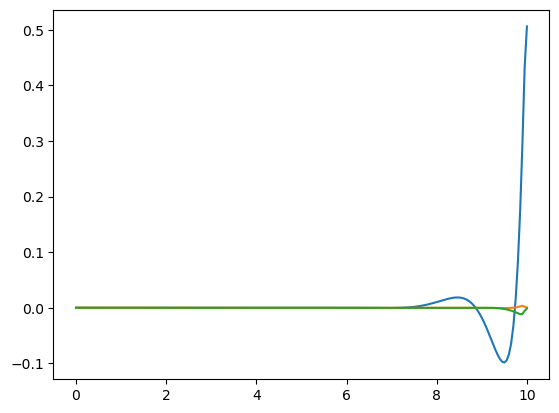

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x00000000010084A0>

In [20]:
plot(thist,xtraj[4,:])
plot(thist,xtraj[5,:])
plot(thist,xtraj[6,:])

In [21]:
xtraj[:, Nt-1]

12-element Vector{Float64}:
 -1.3583256328106226e-5
  0.000497626757837132
 -0.006659502323230745
  0.4338642205890423
  0.002085214960771695
 -0.005427422679623192
 -0.0010853566481986432
  0.21383710754945037
  0.38884325639727296
  2.861016660312433
  0.01600904925301618
  0.18912757376225872

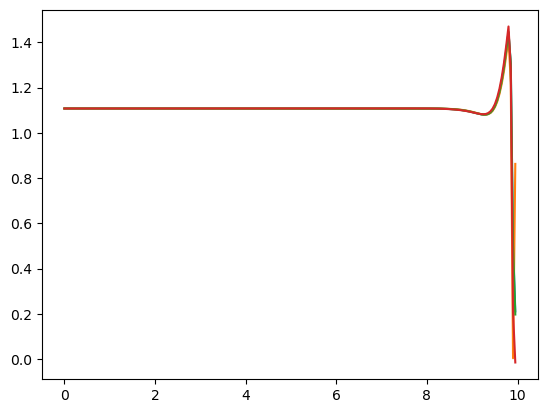

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000001101DC0>

In [22]:
plot(thist[1:Nt-1],utraj[1,:])
plot(thist[1:Nt-1],utraj[2,:])
plot(thist[1:Nt-1],utraj[3,:])
plot(thist[1:Nt-1],utraj[4,:])

## Visualization

In [23]:
using TrajOptPlots
using MeshCat
using StaticArrays

vis = Visualizer()
render(vis)

┌ Warning: Error requiring `MathOptInterface` from `Optim`
│   exception =
│    LoadError: UndefVarError: VariablesContainer not defined
│    Stacktrace:
│      [1] getproperty(x::Module, f::Symbol)
│        @ Base .\Base.jl:35
│      [2] top-level scope
│        @ C:\Users\g.kirillov\.julia\packages\Optim\DV9Sq\ext\OptimMOIExt.jl:22
│      [3] include
│        @ .\Base.jl:419 [inlined]
│      [4] _include(mapexpr::Function, m::Module, path::String)
│        @ PackageExtensionCompat C:\Users\g.kirillov\.julia\packages\PackageExtensionCompat\BTCUg\src\PackageExtensionCompat.jl:12
│      [5] top-level scope
│        @ none:1
│      [6] eval
│        @ .\boot.jl:373 [inlined]
│      [7] eval
│        @ C:\Users\g.kirillov\.julia\packages\Optim\DV9Sq\src\Optim.jl:17 [inlined]
│      [8] (::Optim.var"#153#156")()
│        @ Optim C:\Users\g.kirillov\.julia\packages\Requires\1eCOK\src\require.jl:101
│      [9] macro expansion
│        @ timing.jl:299 [inlined]
│     [10] err(f::Any, listener

MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), Set{Any}(), ip"127.0.0.1", 8700))

In [24]:
TrajOptPlots.set_mesh!(vis, a)

false

In [25]:
function change_state_form(x)
    out = zeros(13)
    out[1:3] .= x[1:3]
    q = UnitQuaternion(RotZYX(x[6], x[5], x[4]))
    out[4] = q.w
    out[5] = q.x
    out[6] = q.y
    out[7] = q.z
    out[8:13] .= x[7:12]
    return out
end

change_state_form (generic function with 1 method)

In [26]:
X1 = [SVector{13}(change_state_form(x)) for x in eachcol(xtraj)];

visualize!(vis, a, thist[end], X1)

# Feasible angles visualization

In [27]:
# Number of divisions for the sphere
Count = 20

# Generate the sphere mesh
θ = range(0, stop=π, length=Count)
ϕ = range(0, stop=2π, length=Count)
X = [sin(t)*cos(p) for t in θ, p in ϕ]
Y = [sin(t)*sin(p) for t in θ, p in ϕ]
Z = [cos(t) for t in θ, _ in ϕ]

20×20 Matrix{Float64}:
  1.0         1.0         1.0        …   1.0         1.0         1.0
  0.986361    0.986361    0.986361       0.986361    0.986361    0.986361
  0.945817    0.945817    0.945817       0.945817    0.945817    0.945817
  0.879474    0.879474    0.879474       0.879474    0.879474    0.879474
  0.789141    0.789141    0.789141       0.789141    0.789141    0.789141
  0.677282    0.677282    0.677282   …   0.677282    0.677282    0.677282
  0.546948    0.546948    0.546948       0.546948    0.546948    0.546948
  0.401695    0.401695    0.401695       0.401695    0.401695    0.401695
  0.245485    0.245485    0.245485       0.245485    0.245485    0.245485
  0.0825793   0.0825793   0.0825793      0.0825793   0.0825793   0.0825793
 -0.0825793  -0.0825793  -0.0825793  …  -0.0825793  -0.0825793  -0.0825793
 -0.245485   -0.245485   -0.245485      -0.245485   -0.245485   -0.245485
 -0.401695   -0.401695   -0.401695      -0.401695   -0.401695   -0.401695
 -0.546948   -0.54

## iLQR iterations

In [28]:
xgoal = [0.0; 0; 0; pi/6; 0; 0; 0; 0; 0; 0; 0; 0]

12-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.5235987755982988
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [29]:
# ошибку вычисляем с помощью матриц вращения, потом перевести в angleaxis. Вывести только угол ошибки
function calculate_error(last_pos)
    ang_error = 0.0
    pos_error = 0.0
    r_des = xgoal[1:3]
    euler_des = xgoal[4:6]
    x = last_pos
    r = x[1:3]
    euler = x[4:6]
    R_des = RotZYX(euler_des[3], euler_des[2], euler_des[1])
    R = RotZYX(euler[3], euler[2], euler[1])
    err_matrix = R * inv(R_des)
    ang_error = AngleAxis(err_matrix).theta
    pos_error = norm(r-r_des)
    return ang_error + pos_error
end

calculate_error (generic function with 1 method)

In [30]:
e = [0.0, 0.0, 1.0]
function get_euler_angles(n)
        if norm(n) < 1e-8
            next!(bar)
            # print(n)
            return NaN
        end
        n = n / norm(n)
        pitch = cross(e, n)
        if norm(pitch) < 1e-8
            next!(bar)
            # print(n, pitch)
            return NaN
        end
        pitch = pitch / norm(pitch)
        b = cross(pitch, n)
        if norm(b) < 1e-8
            next!(bar)
            # print(n, pitch, b)
            return NaN
        end
        b = b / norm(b)

        T = RotZYX([n pitch b])
        # correct inital conditions
        return [T.theta3, T.theta2, T.theta1]
end

get_euler_angles (generic function with 1 method)

## Set up desired state

In [ ]:
using ProgressMeter
bar = Progress(Count * Count, desc="Iteration: ")
#DDP Algorithm
#Initial Rollout
e = [0.0, 0.0, 1.0]
Hmap_iterations = zeros(Count,Count)
Hmap_time = zeros(Count,Count)
Hmap_error = zeros(Count,Count)
Hmap_cost = zeros(Count, Count)
for i in 1:Count
    for j in 1:Count
        t_start = time()
        iter = 0
        # Tramsform sphere coords to euler angles:
        n = [X[i,j], Y[i,j], Z[i,j]]

        euler_angs = get_euler_angles(n)

        if any(isnan, euler_angs)
            Hmap_iterations[i,j] = NaN
            Hmap_time[i,j] = NaN
            Hmap_error[i,j] = NaN
            Hmap_cost[i,j] = NaN
            continue
        end
        
        x0[4:6] .= euler_angs
        # correct initial trajectory
        xtraj = kron(ones(1,Nt), x0)
        utraj = zeros(Nu, Nt-1) .+ uhover
        for k = 1:(Nt-1)
            xtraj[:,k+1] .= dynamics_rk4(xtraj[:,k],utraj[:,k])
        end
        J = cost(xtraj,utraj)
        # iLQR start
        p = ones(Nx,Nt)
        P = zeros(Nx,Nx,Nt)
        d = ones(Nu,Nt-1)
        K = zeros(Nu,Nx,Nt-1)
        ΔJ = 1.0
        
        xn = zeros(Nx,Nt)
        un = zeros(Nu,Nt-1)
        
        gx = zeros(Nx)
        gu = zeros(Nu)
        Gxx = zeros(Nx,Nx)
        Guu = zeros(Nu)
        Gxu = zeros(Nx)
        Gux = zeros(Nx)
        
        Jp = 0
        stop = false
        while abs(Jp-J) >  5 * 1e-5
            if stop
                break
            end
            iter += 1    
            
            #Backward Pass
            ΔJ = backward_pass!(p,P,d,K)
            if isnan(ΔJ)
                stop = true
                break
            end
            #Forward rollout with line search
            xn[:,1] = xtraj[:,1]
            α = 1.0
            
            # display(K[:,:,1] * (xn[:,1]-xtraj[:,1]))
            # display(utraj[:,1] - α*d[:,1] - K[:,:,1] * (xn[:,1]-xtraj[:,1]))
            
            for k = 1:(Nt-1)
                un[:,k] .= utraj[:,k] - α*d[:,k] - K[:,:,k] * (xn[:,k]-xtraj[:,k])
                try
                    xn[:,k+1] .= dynamics_rk4(xn[:,k],un[:,k])
                catch err
                    stop = true 
                end
            end
            Jn = cost(xn,un)
            # display(Jn)
            while isnan(Jn) || Jn > (J - 1e-2*α*ΔJ)
                α = 0.5*α
                for k = 1:(Nt-1)
                    un[:,k] .= utraj[:,k] - α*d[:,k] - K[:,:,k] * (xn[:,k]-xtraj[:,k])
                    try
                        xn[:,k+1] .= dynamics_rk4(xn[:,k],un[:,k])
                    catch err
                        # print("Current x: $(xn[:,k])\n")
                        # print("Current u: $(un[:,k-1])\n")
                        # print("Previous x: $(xn[:,k-2])\n")
                        stop = true
                    end
                end
                Jn = cost(xn,un)
                # display(Jn)
            end
            
            Jp = J
            J = Jn
            xtraj .= xn
            utraj .= un

        end
        if stop
            Hmap_iterations[i,j] = NaN
            Hmap_time[i,j] = NaN
            Hmap_error[i,j] = NaN
            Hmap_cost[i,j] = NaN
        else
            Hmap_iterations[i,j] = iter
            Hmap_time[i,j] = time() - t_start
            Hmap_error[i,j] = calculate_error(xtraj[:, Nt])
            Hmap_cost[i,j] = J
        end
        next!(bar)
    end
end

Iteration:  59%|████████████████████████                |  ETA: 0:25:45

## Saving obtained iteration heatmap

In [ ]:
@save "euler/ua/rk4/Hmap_euler_rk4_iter.jld2" Hmap_iterations
@save "euler/ua/rk4/Hmap_euler_rk4_time.jld2" Hmap_time
@save "euler/ua/rk4/Hmap_euler_rk4_error.jld2" Hmap_error
@save "euler/ua/rk4/Hmap_euler_rk4_cost.jld2" Hmap_cost

## Graph Plotting

In [ ]:
@load "euler/ua/rk4/Hmap_euler_rk4_iter.jld2" Hmap_iterations
@load "euler/ua/rk4/Hmap_euler_rk4_time.jld2" Hmap_time
@load "euler/ua/rk4/Hmap_euler_rk4_error.jld2" Hmap_error
@load "euler/ua/rk4/Hmap_euler_rk4_cost.jld2" Hmap_cost

In [ ]:
# Start the figure
pygui(true)
Hmap_norm = Hmap_cost ./ maximum(filter(!isnan, Hmap_cost))
fig = PyPlot.figure()
ax = fig.add_subplot(111, projection="3d")
# Custom colormap
cmap = PyPlot.get_cmap("cividis", 256)
cmap.set_bad("red")     # NaNs or masked values
# newcolors = cmap(LinRange(0, 1, 256))
# Red for failing intial conditions
# red = [256/256; 0/256; 0/256; 1]
# newcolors[:1, :] .= red
# newcmp = PyPlot.matplotlib.colors.ListedColormap(newcolors)
colors = cmap.(Hmap_norm)

psm = ax.plot_surface(X, Y, Z,
    facecolors=colors,
    linewidth=0.5, alpha=0.5,
    shade=false)

ax.set_box_aspect([1,1,1])  # Equal aspect ratio
cbar = fig.colorbar(psm, ax=ax)
cbar.set_ticks([0, 1])  # Show ticks at the normalized range
cbar.set_ticklabels([0, maximum(filter(!isnan, Hmap_cost))])  # Map ticks back to the original data range
PyPlot.tight_layout()
PyPlot.show()